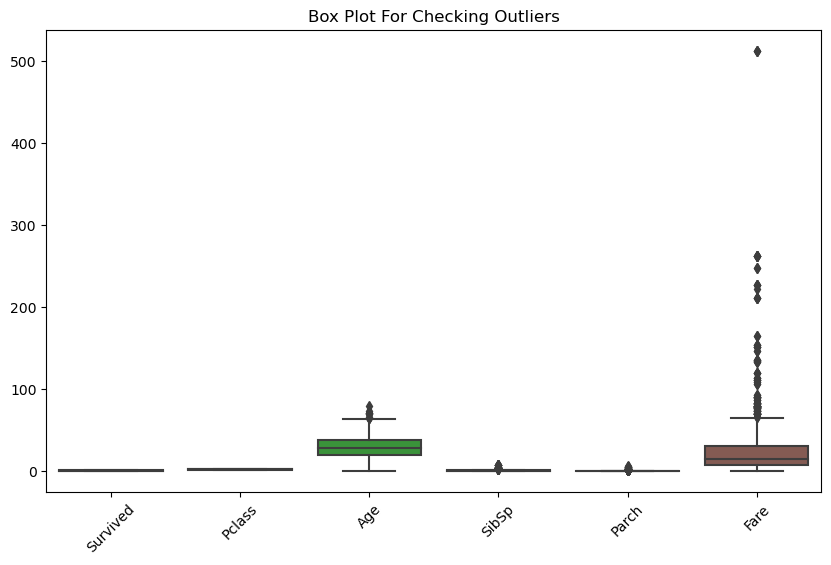

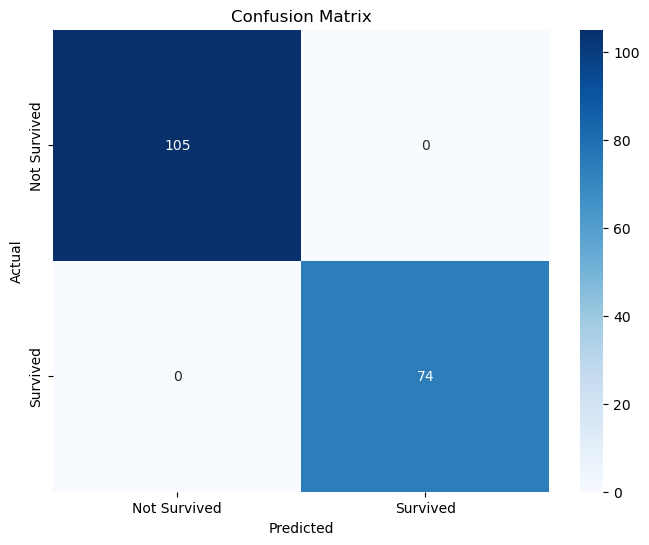

Overall Accuracy for Best Model: 100.0%


In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def read_csv(file_path):
    df = pd.read_csv(file_path)
    return df

def classify_columns(data_frame):
    categorical_columns = data_frame.select_dtypes(include=['object']).columns
    numeric_columns = data_frame.select_dtypes(include=['int64', 'float64']).columns
    return list(categorical_columns), list(numeric_columns)

def preprocess_categorical_data(data_frame, column_name):
    if column_name in ['Sex', 'Embarked']:
        mapping = {'male': 0, 'female': 1} if column_name == 'Sex' else {'S': 0, 'C': 1, 'Q': 2}
        data_frame[column_name] = data_frame[column_name].map(mapping)
    else:
        imputer = SimpleImputer(strategy='most_frequent')
        transformed_values = imputer.fit_transform(data_frame[[column_name]])
        data_frame[column_name] = transformed_values.ravel()
    return data_frame

def preprocess_numeric_data(data_frame, column_name):
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    data_frame[column_name] = scaler.fit_transform(imputer.fit_transform(data_frame[[column_name]]))
    return data_frame

def remove_numeric_outliers(df, multiplier=1):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numeric_columns:
        if column != 'Survived': 
            q1, q3 = df[column].quantile(0.25), df[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound, upper_bound = q1 - multiplier * iqr, q3 + multiplier * iqr
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

def feature_selection(dataset, target_variable, k=5):
    selected_columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    if target_variable not in dataset.columns:
        raise ValueError(f"Target variable '{target_variable}' not found in the dataset columns.")
    if target_variable not in selected_columns:
        selected_columns = [target_variable] + selected_columns
    try:
        selected_dataset = dataset[selected_columns]
    except KeyError as e:
        raise KeyError(f"One or more specified columns not found in the dataset: {e}")
    return selected_dataset, dataset[target_variable]

def train_and_evaluate_models(X_train, y_train, X_test, y_test, target_variable):
    if target_variable == 'Survived':
        y_train, y_test = y_train.astype(int), y_test.astype(int)
        models = [LogisticRegression(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42)]
        accuracies = {}
        for model in models:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            accuracies[type(model).__name__] = accuracy
        best_model = max(accuracies.items(), key=lambda x: x[1])
        return best_model[0], best_model[1]
    else:
        raise ValueError("Invalid target variable name")

def train_best_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

def plot_box_plots(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)
    plt.title("Box Plot For Checking Outliers")
    plt.xticks(rotation=45)
    plt.show()

def main():
    file_path = 'Titanic-Dataset.csv'
    dataset = read_csv(file_path)
    dataset, target_variable = feature_selection(dataset, 'Survived', k=5)
    categorical_columns, numeric_columns = classify_columns(dataset)
    plot_box_plots(dataset)
    for column in categorical_columns + numeric_columns:
        if column in categorical_columns and column != 'Survived': 
            dataset = preprocess_categorical_data(dataset, column)
        elif column != 'Survived':  
            dataset = preprocess_numeric_data(dataset, column)
    survived_column = dataset['Survived']
    label_encoder = LabelEncoder()
    target_variable = label_encoder.fit_transform(survived_column)
    X_train, X_test, y_train, y_test = train_test_split(dataset, target_variable.astype(int), test_size=0.2, random_state=42)
    X_train_no_outliers = remove_numeric_outliers(X_train)
    best_model = RandomForestClassifier(random_state=42)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    report = classification_report(y_test, y_pred, target_names=['Not Survived', 'Survived'])
    accuracy = accuracy_score(y_test, y_pred)
    return best_model, accuracy

if __name__ == "__main__":
    best_model, accuracy = main()
    print(f"Overall Accuracy for Best Model: {accuracy*100}%")
